In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_380.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_517.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_364.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_258.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_237.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_476.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_563.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_159.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_464.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_518.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_141.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_398.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_442.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_443.jpg
/kaggl

# Importing Libraries

In [2]:
# Core
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Paths
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

# Hyperparameters
CFG = dict(
    seed = 77,
    batch_size = 16,
    img_size = (299,299),
    epochs = 5,
    patience = 5
)

# Data Agumentation

In [7]:
# Augment train set only
train_data_generator = ImageDataGenerator(
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Processing & Visualization

In [8]:
# Connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Found 475 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Classes:['cats', 'dogs']


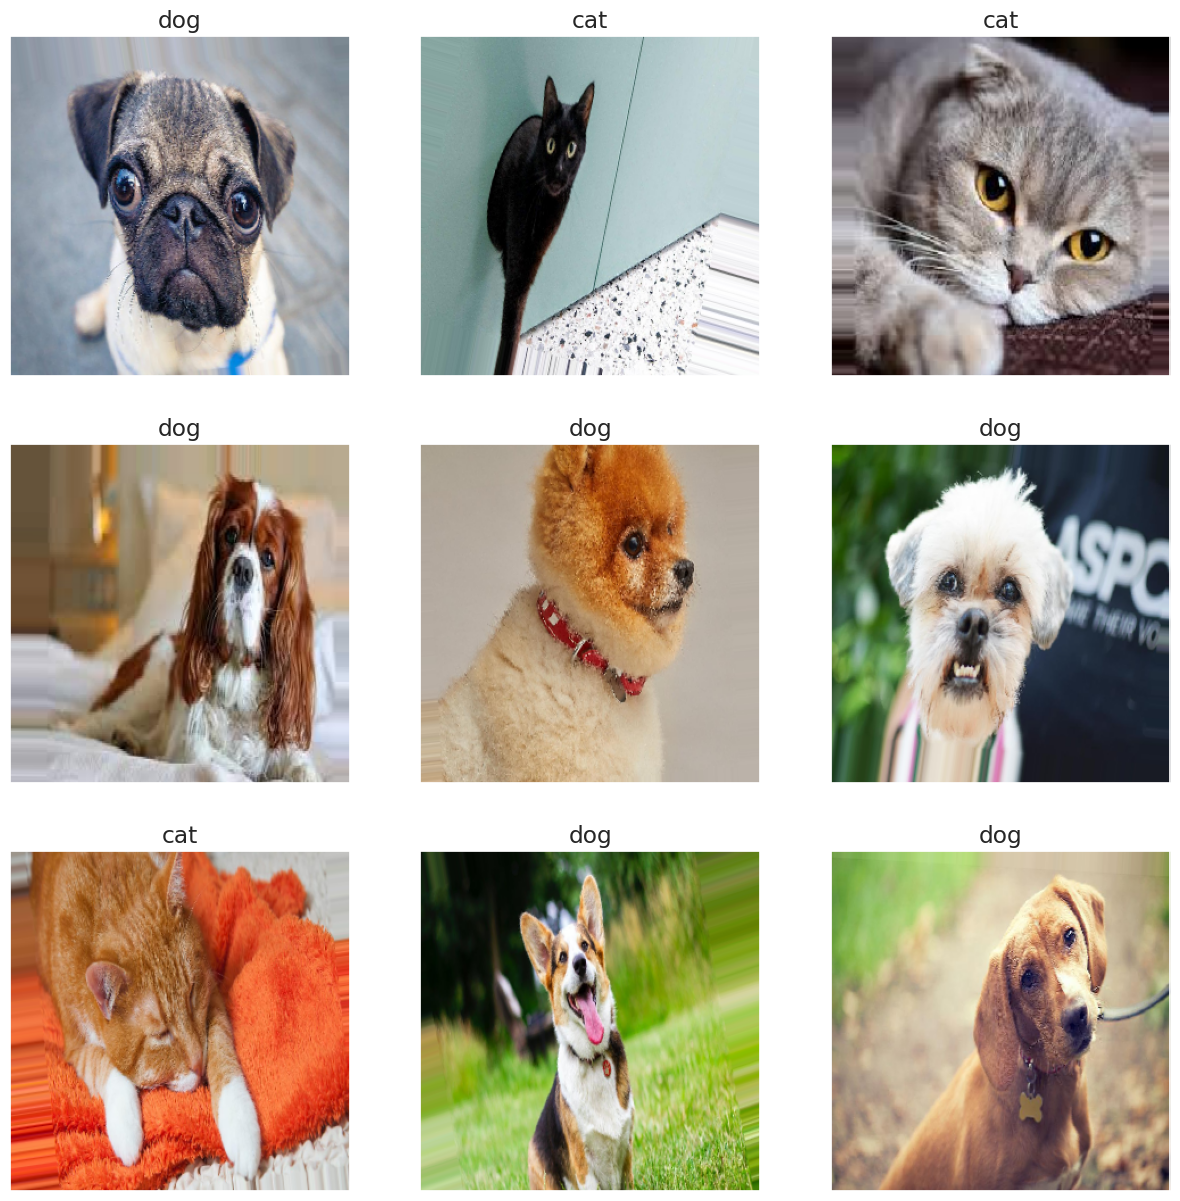

In [9]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = train_generator.next()
    imgs = (batch[0] + 1) * 127.5
    label = int(batch[1][0][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()

# Transfer learning

In [10]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 1s 0us/step


# Model Training

In [11]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='trained_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [12]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/5
29/29 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.8976
Epoch 1: val_loss improved from inf to 0.10320, saving model to trained_model.h5
29/29 [==============================] - 38s 756ms/step - loss: 0.6010 - accuracy: 0.8976 - val_loss: 0.1032 - val_accuracy: 0.9750
Epoch 2/5
29/29 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9739
Epoch 2: val_loss improved from 0.10320 to 0.04209, saving model to trained_model.h5
29/29 [==============================] - 15s 518ms/step - loss: 0.0833 - accuracy: 0.9739 - val_loss: 0.0421 - val_accuracy: 0.9875
Epoch 3/5
29/29 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9804
Epoch 3: val_loss improved from 0.04209 to 0.00668, saving model to trained_model.h5
29/29 [==============================] - 14s 489ms/step - loss: 0.0358 - accuracy: 0.9804 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 4/5
29/29 [==============================] - ETA: 0s - loss: 0.0971 

# Learning curves

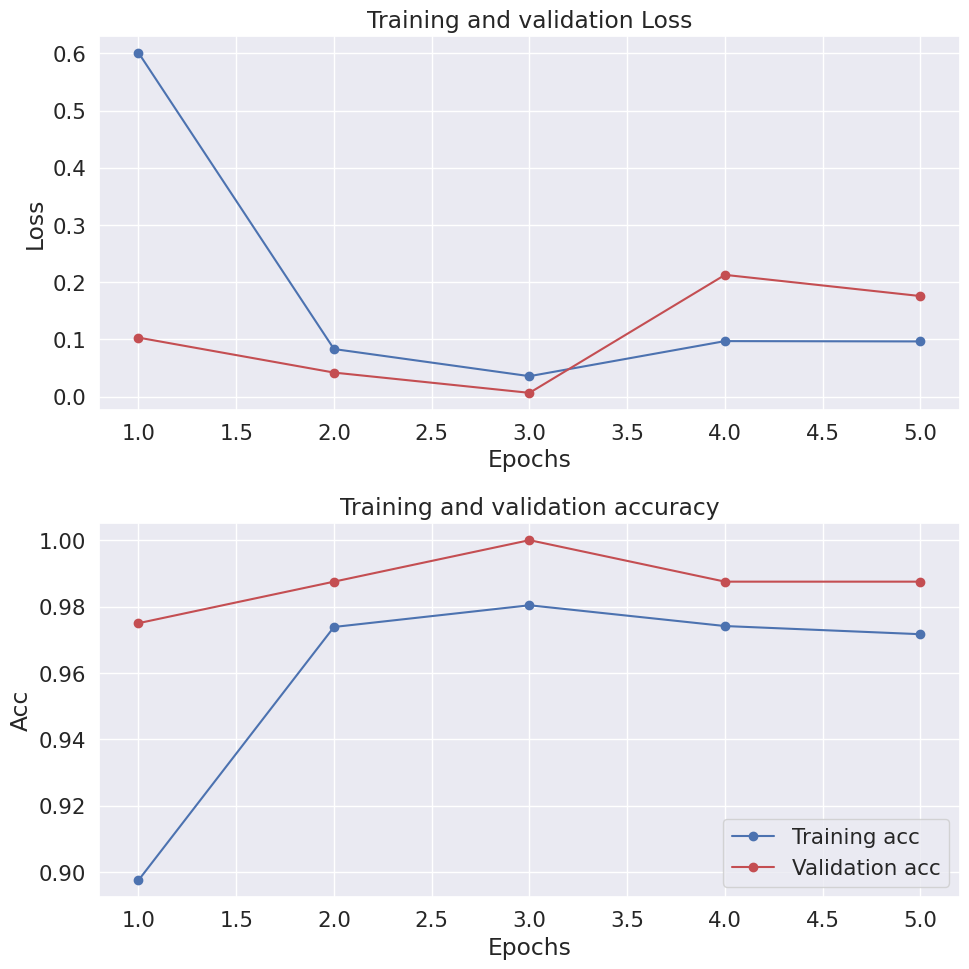

In [13]:
# History
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Loss
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation

In [14]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1715153455734253
Val accuracy: 0.9878048896789551


In [15]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15108293294906616
Test accuracy: 0.9785714149475098


9/9 [==============================] - 4s 128ms/step


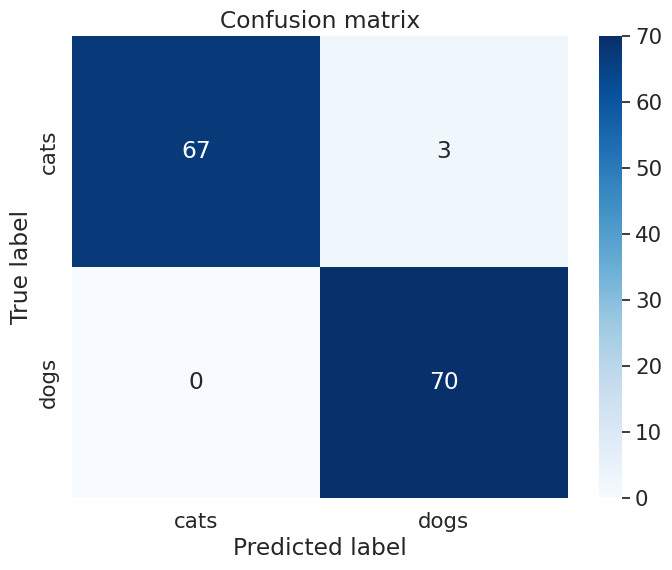

In [16]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()